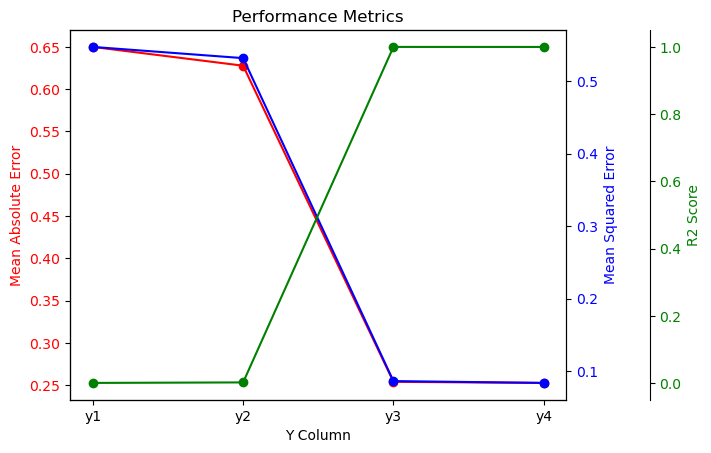

Loaded Metrics:
   y_column       MAE       MSE  R2_Score
0        y1  0.389694  0.216381  0.999594
1        y2  0.383225  0.215125  0.999596
2        y3  0.239759  0.074514  0.999441
3        y4  0.265019  0.105540  0.010890
4        y1  0.389694  0.216381  0.999594
5        y2  0.383225  0.215125  0.999596
6        y3  0.239759  0.074514  0.999441
7        y4  0.265019  0.105540  0.010890
8        y1  0.650009  0.547400  0.001290
9        y2  0.627791  0.531919  0.002812
10       y3  0.253912  0.086062  1.000000
11       y4  0.252630  0.083527  0.999930


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine, Column, Float, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
import matplotlib.pyplot as plt
import os
import subprocess
import sqlite3

Base = declarative_base()


class TrainingData(Base):
    __tablename__ = 'training_data'

    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y1 = Column(Float)
    y2 = Column(Float)
    y3 = Column(Float)
    y4 = Column(Float)


class DataAnalysisBase:
    """
    Base class for data analysis.
    """

    def __init__(self, train_file, ideal_file, test_file):
        """
        Initialize DataAnalysisBase instance.

        Args:
            train_file (str): Path to the training data file.
            ideal_file (str): Path to the ideal data file.
            test_file (str): Path to the test data file.
        """
        self.train_file = train_file
        self.ideal_file = ideal_file
        self.test_file = test_file
        self.train_data = None
        self.ideal_data = None
        self.test_data = None

    def read_data(self):
        """
        Read the data from CSV files into DataFrames.
        """
        self.train_data = pd.read_csv(self.train_file)
        self.ideal_data = pd.read_csv(self.ideal_file)
        self.test_data = pd.read_csv(self.test_file)

    def compile_database(self, database_file):
        engine = create_engine(f'sqlite:///{database_file}')
        Base.metadata.create_all(engine)
        Session = sessionmaker(bind=engine)
        session = Session()

        for _, row in self.train_data.iterrows():
            data_row = TrainingData(x=row['x'], y1=row['y1'], y2=row['y2'], y3=row['y3'], y4=row['y4'])
            session.add(data_row)

        session.commit()
        session.close()

    def visualize_training_data(self):
        """
        Visualize the training data.
        """
        plots = []
        for y_col in self.train_data.columns[1:]:
            p = figure(title=f"x vs {y_col}", x_axis_label='x', y_axis_label=y_col)
            p.scatter(self.train_data['x'], self.train_data[y_col], color='blue')
            plots.append(p)
        grid = gridplot(plots, ncols=2)
        show(grid)

    def visualize_test_data(self):
        """
        Visualize the test data.
        """
        p = figure(title="Test_data['x'] vs Test_data['y']", x_axis_label="Test_data['x']", y_axis_label="Test_data['y']")
        p.scatter(self.test_data['x'], self.test_data['y'], color='green')
        show(p)


class DataAnalysis(DataAnalysisBase):
    """
    Data analysis class with additional methods.
    """

    def __init__(self, train_file, ideal_file, test_file):
        super().__init__(train_file, ideal_file, test_file)

    def fit_polynomial_models(self):
        """
        Fit polynomial models to the training data.

        Returns:
            dict: A dictionary mapping each y column to its polynomial model.
        """
        models = {}
        for y_col in self.train_data.columns[1:]:
            model = np.polyfit(self.train_data['x'], self.train_data[y_col], 3)
            models[y_col] = model
        return models

    def predict(self, models):
        """
        Predict the values using the fitted polynomial models.

        Args:
            models (dict): A dictionary mapping each y column to its polynomial model.

        Returns:
            dict: A dictionary mapping each y column to its predicted values.
        """
        predictions = {}
        for y_col, model in models.items():
            poly_func = np.poly1d(model)
            predictions[y_col] = poly_func(self.ideal_data['x'])
        return predictions

    def calculate_performance_metrics(self, models):
        """
        Calculate performance metrics for the fitted polynomial models.

        Args:
            models (dict): A dictionary mapping each y column to its polynomial model.

        Returns:
            dict: A dictionary mapping each y column to its performance metrics (MAE, MSE, R2 Score).
        """
        if self.train_data is None:
            raise Exception("Training data is not loaded")

        metrics = {}
        for y_col, model in models.items():
            predictions = self.predict({y_col: model})
            y_true = self.train_data[y_col]
            y_pred = predictions[y_col]
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            metrics[y_col] = {'MAE': mae, 'MSE': mse, 'R2 Score': r2}
        return metrics

    def find_best_ideal_functions(self):
        """
        Find the best ideal functions for each y column.

        Returns:
            dict: A dictionary mapping each y column to the best ideal function.
        """
        ideal_functions = {}
        for y_col in self.train_data.columns[1:]:
            differences = {}
            for ideal_col in self.ideal_data.columns[1:]:
                difference = np.sum(np.abs(self.train_data[y_col] - self.ideal_data[ideal_col]))
                differences[ideal_col] = difference
            best_ideal_col = min(differences, key=differences.get)
            ideal_functions[y_col] = best_ideal_col
        return ideal_functions

    def calculate_maximum_deviation(self):
        """
        Calculate the maximum deviation for each y column.

        Returns:
            dict: A dictionary mapping each y column to its maximum deviation.
        """
        max_deviations = {}
        for y_col, ideal_col in self.find_best_ideal_functions().items():
            max_deviation = np.max(np.abs(self.train_data[y_col] - self.ideal_data[ideal_col]))
            max_deviations[y_col] = max_deviation
        return max_deviations

    def plot_performance_metrics(self, metrics):
        """
        Plot the performance metrics.

        Args:
            metrics (dict): A dictionary mapping each y column to its performance metrics.

        """
        x = list(metrics.keys())
        mae = [metric['MAE'] for metric in metrics.values()]
        mse = [metric['MSE'] for metric in metrics.values()]
        r2 = [metric['R2 Score'] for metric in metrics.values()]

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Y Column')
        ax1.set_ylabel('Mean Absolute Error', color='red')
        ax1.plot(x, mae, color='red', marker='o')
        ax1.tick_params(axis='y', labelcolor='red')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Mean Squared Error', color='blue')
        ax2.plot(x, mse, color='blue', marker='o')
        ax2.tick_params(axis='y', labelcolor='blue')

        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('R2 Score', color='green')
        ax3.plot(x, r2, color='green', marker='o')
        ax3.tick_params(axis='y', labelcolor='green')

        plt.title('Performance Metrics')
        plt.show()

    def save_to_database(self, metrics):
        """
        Save the performance metrics to a database.

        Parameters:
        - metrics (dict): Dictionary containing the performance metrics.

        Returns:
        - None
        """
        if len(metrics) == 0:
            raise Exception("No metrics provided")

        # Connect to the database
        conn = sqlite3.connect('data_analysis.db')
        cursor = conn.cursor()

        # Create a table for metrics if it doesn't exist
        cursor.execute('''CREATE TABLE IF NOT EXISTS metrics
                          (y_column TEXT, MAE REAL, MSE REAL, R2_Score REAL)''')

        # Insert the metrics into the table
        for y_col, metric in metrics.items():
            cursor.execute("INSERT INTO metrics VALUES (?, ?, ?, ?)",
                           (y_col, metric['MAE'], metric['MSE'], metric['R2 Score']))

        # Commit the changes and close the connection
        conn.commit()
        conn.close()

    def load_from_database(self):
        """
        Load the performance metrics from the database.

        Returns:
        - DataFrame: DataFrame containing the loaded metrics.
        """
        # Connect to the database
        conn = sqlite3.connect('data_analysis.db')

        # Read the data from the database
        df = pd.read_sql_query("SELECT * FROM metrics", conn)

        # Close the connection
        conn.close()

        return df


# Set the file paths
train_file = 'train.csv'
ideal_file = 'ideal.csv'
test_file = 'test.csv'

# Create an instance of DataAnalysis
data_analysis = DataAnalysis(train_file, ideal_file, test_file)

# Read the data from CSV files
data_analysis.read_data()

# Visualize the training data
data_analysis.visualize_training_data()

# Visualize the test data
data_analysis.visualize_test_data()

# Fit polynomial models to the training data
models = data_analysis.fit_polynomial_models()

# Predict the values using the fitted polynomial models
predictions = data_analysis.predict(models)

# Calculate performance metrics for the fitted polynomial models
metrics = data_analysis.calculate_performance_metrics(models)

# Find the best ideal functions for each y column
ideal_functions = data_analysis.find_best_ideal_functions()

# Calculate the maximum deviation for each y column
max_deviations = data_analysis.calculate_maximum_deviation()

# Plot the performance metrics
data_analysis.plot_performance_metrics(metrics)

# Save the performance metrics to a database
data_analysis.save_to_database(metrics)

# Load the performance metrics from the database
loaded_metrics = data_analysis.load_from_database()
print("Loaded Metrics:")
print(loaded_metrics)